In [27]:
%matplotlib inline
from detector import Detector
from utils import draw_bounding_boxes

In [28]:
state_file = "./epoch_41.pth.tar"
detector = Detector(state_file)

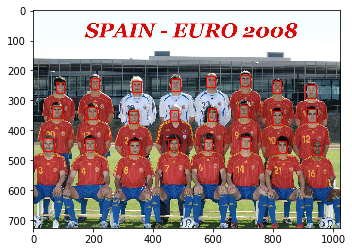

In [32]:
test_image = "./images/test.jpg"
bboxes = detector.infer(test_image)
draw_bounding_boxes(test_image, bboxes)